# ** CPSC 8810 Deep Learning - HW1-3 **
---

## Introduction
_**Note:** This assignment makes use of the MNIST dataset_

The main objective of this assignments:
* Fit network with random labels
* Compare number of parameters vs generalization
* Compare flatness vs generalization

In [1]:
import tensorflow as tf
import cv2
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.decomposition import PCA

tf.__version__
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## MNIST Dataset Preparation and Visualization

In [77]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True);

train_num = data.train.num_examples
valid_num = data.validation.num_examples
test_num = data.test.num_examples
img_flatten = 784
img_size = 28
num_classes = 10
print("Training Dataset Size:",train_num)
print("Validation Dataset Size:",valid_num)
print("Testing Dataset Size:",test_num)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Training Dataset Size: 55000
Validation Dataset Size: 5000
Testing Dataset Size: 10000


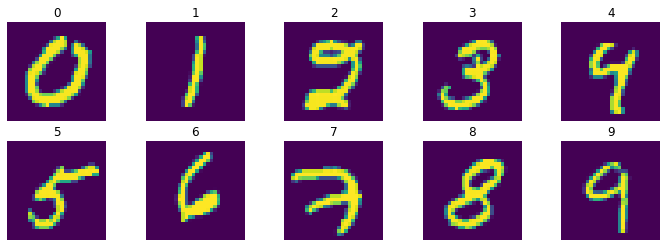

In [78]:
fig, axs = plt.subplots(2,5)
fig.set_size_inches(12,4)
for i in range(10):
    idx = np.where(np.argmax(data.train.labels,1)==i)[0][0]
    axs[int(i/5),i%5].imshow(data.train.images[idx].reshape(28,28))
    axs[int(i/5),i%5].set_title(str(i))
    axs[int(i/5),i%5].axis('off')

## 1.1 Model 1 Architecture

In [79]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

conv1 = tf.layers.conv2d(inputs=input_x,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=16,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);
sens_op = tf.norm(tf.gradients(loss,input_x))

### 1.2 Training Model 1

In [80]:
train_loss_list1 = []
train_acc_list1 = []
test_loss_list1 = []
test_acc_list1 = []
sens_list1 = []
session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = [4,16,64,256,512,1024,2048,4096]
for i in range(len(BATCH_SIZE)):
    for j in range(int(data.train.num_examples/BATCH_SIZE[i])):
        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE[i])
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list1.append(train_loss)
    train_acc_list1.append(train_acc)
    test_loss, test_acc, sens = session.run([loss,acc_op,sens_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list1.append(test_loss)
    test_acc_list1.append(test_acc)
    sens_list1.append(sens)
    msg = "Batch Size: {0:>4}, Training Loss: {1:>1.4}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.4}, Test Accuracy: {4:>6.1%}, Sensitivity: {5:>1.4}"
    print(msg.format(BATCH_SIZE[i], train_loss, train_acc, test_loss, test_acc, sens))

Batch Size:    4, Training Loss: 0.001657, Training Accuracy: 100.0%, Test Loss: 0.1354, Test Accuracy:  96.5%, Sensitivity: 0.06897
Batch Size:   16, Training Loss: 0.0005888, Training Accuracy: 100.0%, Test Loss: 0.08801, Test Accuracy:  97.6%, Sensitivity: 0.05403
Batch Size:   64, Training Loss: 0.002793, Training Accuracy: 100.0%, Test Loss: 0.05398, Test Accuracy:  98.5%, Sensitivity: 0.04489
Batch Size:  256, Training Loss: 0.02711, Training Accuracy:  99.2%, Test Loss: 0.04781, Test Accuracy:  98.8%, Sensitivity: 0.04366
Batch Size:  512, Training Loss: 0.0249, Training Accuracy:  99.0%, Test Loss: 0.04805, Test Accuracy:  98.8%, Sensitivity: 0.04543
Batch Size: 1024, Training Loss: 0.01596, Training Accuracy:  99.7%, Test Loss: 0.04842, Test Accuracy:  98.8%, Sensitivity: 0.04585
Batch Size: 2048, Training Loss: 0.01179, Training Accuracy:  99.8%, Test Loss: 0.04853, Test Accuracy:  98.8%, Sensitivity: 0.04641
Batch Size: 4096, Training Loss: 0.01434, Training Accuracy:  99.5%

Text(0.5, 1.0, 'Accuracy vs Batch Size')

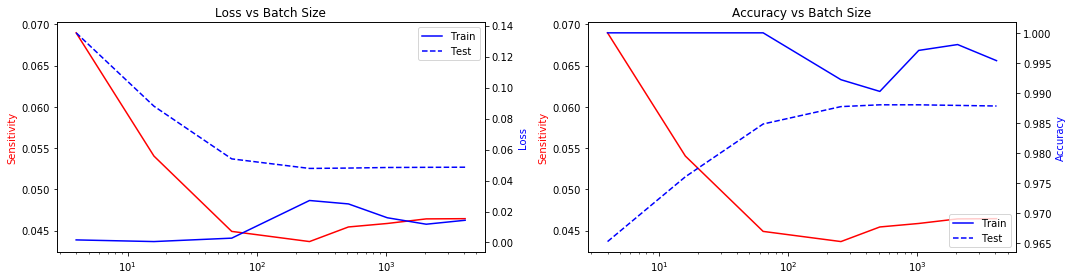

In [81]:
fig,axs=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_tight_layout('tight')
axs[0].plot(BATCH_SIZE,sens_list1,'r')
axs[0].set_xscale('log')
axs[0].set_ylabel('Sensitivity')
axs[0].yaxis.label.set_color('red')
axs1 = axs[0].twinx()
axs1.plot(BATCH_SIZE, train_loss_list1,'b')
axs1.plot(BATCH_SIZE, test_loss_list1,'b--')
axs1.set_xscale('log')
axs1.set_ylabel('Loss')
axs1.yaxis.label.set_color('blue')
axs1.set_xlabel('Batch Size(log scale)')
axs1.legend(['Train','Test'])
axs1.set_title('Loss vs Batch Size')

axs[1].plot(BATCH_SIZE,sens_list1,'r')
axs[1].set_xscale('log')
axs[1].set_ylabel('Sensitivity')
axs[1].yaxis.label.set_color('red')
axs2 = axs[1].twinx()
axs2.plot(BATCH_SIZE, train_acc_list1,'b')
axs2.plot(BATCH_SIZE, test_acc_list1,'b--')
axs2.set_ylabel('Accuracy')
axs2.yaxis.label.set_color('blue')
axs2.set_xlabel('Batch Size(log scale)')
axs2.legend(['Train','Test'])
axs2.set_title('Accuracy vs Batch Size')

___
## Model 2 Architecture

In [36]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)
learning_rate = tf.placeholder(tf.float32)

conv1 = tf.layers.conv2d(inputs=input_x,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu);
pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=2,strides=2);
conv2 = tf.layers.conv2d(inputs=pool1,filters=16,kernel_size=5,padding="same",activation=tf.nn.relu);
pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=2,strides=2);
flat1 = tf.layers.flatten(pool2);
fc1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=fc1,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate);
train_op = optimizer.minimize(loss);
sens_op = tf.norm(tf.gradients(loss,input_x))

### Model 2 Training

In [39]:
train_loss_list2 = []
train_acc_list2 = []
test_loss_list2 = []
test_acc_list2 = []
sens_list2 = []
session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = 64
lr_list = [0.05,0.01,0.005,0.001,0.0005,0.0001]
for i in range(len(lr_list)):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):
        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch,learning_rate:lr_list[i]})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list2.append(train_loss)
    train_acc_list2.append(train_acc)
    test_loss, test_acc, sens = session.run([loss,acc_op,sens_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list2.append(test_loss)
    test_acc_list2.append(test_acc)
    sens_list2.append(sens)
    msg = "Learn rate: {0:>4}, Training Loss: {1:>1.4}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.4}, Test Accuracy: {4:>6.1%}, Sensitivity: {5:>1.4}"
    print(msg.format(lr_list[i], train_loss, train_acc, test_loss, test_acc, sens))

Learn rate: 0.05, Training Loss: 0.2419, Training Accuracy:  90.6%, Test Loss: 0.3656, Test Accuracy:  89.4%, Sensitivity: 0.1805
Learn rate: 0.01, Training Loss: 0.1068, Training Accuracy:  96.9%, Test Loss: 0.1412, Test Accuracy:  95.7%, Sensitivity: 0.1072
Learn rate: 0.005, Training Loss: 0.1422, Training Accuracy:  98.4%, Test Loss: 0.1082, Test Accuracy:  96.7%, Sensitivity: 0.08596
Learn rate: 0.001, Training Loss: 0.09598, Training Accuracy:  96.9%, Test Loss: 0.101, Test Accuracy:  96.9%, Sensitivity: 0.08127
Learn rate: 0.0005, Training Loss: 0.09405, Training Accuracy:  95.3%, Test Loss: 0.09986, Test Accuracy:  97.0%, Sensitivity: 0.08389
Learn rate: 0.0001, Training Loss: 0.05023, Training Accuracy:  98.4%, Test Loss: 0.09919, Test Accuracy:  97.0%, Sensitivity: 0.08346


Text(0.5, 1.0, 'Accuracy vs Learning Rate')

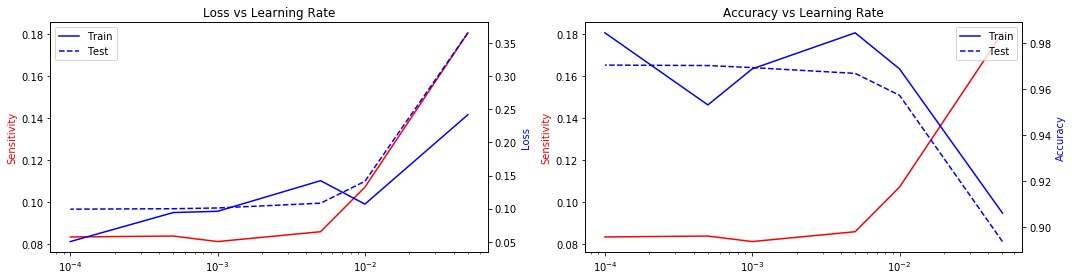

In [56]:
fig,axs=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_tight_layout('tight')
axs[0].plot(lr_list,sens_list2,'r')
axs[0].set_xscale('log')
axs[0].set_ylabel('Sensitivity')
axs[0].yaxis.label.set_color('red')
axs1 = axs[0].twinx()
axs1.plot(lr_list, train_loss_list2,'b')
axs1.plot(lr_list, test_loss_list2,'b--')
axs1.set_xscale('log')
axs1.set_ylabel('Loss')
axs1.yaxis.label.set_color('blue')
axs1.set_xlabel('Learning Rate(log scale)')
axs1.legend(['Train','Test'])
axs1.set_title('Loss vs Learning Rate')

axs[1].plot(lr_list,sens_list2,'r')
axs[1].set_xscale('log')
axs[1].set_ylabel('Sensitivity')
axs[1].yaxis.label.set_color('red')
axs2 = axs[1].twinx()
axs2.plot(lr_list, train_acc_list2,'b')
axs2.plot(lr_list, test_acc_list2,'b--')
axs2.set_ylabel('Accuracy')
axs2.set_xlabel('Learning Rate(log scale)')
axs2.yaxis.label.set_color('blue')
axs2.legend(['Train','Test'])
axs2.set_title('Accuracy vs Learning Rate')

___
## Model 3 Architecture

In [65]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)
learning_rate = tf.placeholder(tf.float32)

flat1 = tf.layers.flatten(inputs=input_x)
h1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
h2 = tf.layers.dense(inputs=h1,units=256,activation=tf.nn.relu);
h3 = tf.layers.dense(inputs=h1,units=128,activation=tf.nn.relu);
h4 = tf.layers.dense(inputs=h1,units=64,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=h4,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate);
train_op = optimizer.minimize(loss);
sens_op = tf.norm(tf.gradients(loss,input_x))

In [67]:
train_loss_list3 = []
train_acc_list3 = []
test_loss_list3 = []
test_acc_list3 = []
sens_list3 = []
session = tf.Session()
session.run(tf.global_variables_initializer())

lr_list = [0.05,0.01,0.005,0.001,0.0005,0.0001]
BATCH_SIZE = 64
for i in range(len(lr_list)):
    for j in range(int(data.train.num_examples/BATCH_SIZE)):
        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE)
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch,learning_rate:lr_list[i]})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list3.append(train_loss)
    train_acc_list3.append(train_acc)
    test_loss, test_acc, sens = session.run([loss,acc_op,sens_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list3.append(test_loss)
    test_acc_list3.append(test_acc)
    sens_list3.append(sens)
    msg = "Learn rate: {0:>4}, Training Loss: {1:>1.4}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.4}, Test Accuracy: {4:>6.1%}, Sensitivity: {5:>1.4}"
    print(msg.format(lr_list[i], train_loss, train_acc, test_loss, test_acc, sens))

Learn rate: 0.05, Training Loss: 0.3494, Training Accuracy:  90.6%, Test Loss: 0.4947, Test Accuracy:  88.0%, Sensitivity: 0.07123
Learn rate: 0.01, Training Loss: 0.2044, Training Accuracy:  92.2%, Test Loss: 0.2929, Test Accuracy:  92.0%, Sensitivity: 0.04312
Learn rate: 0.005, Training Loss: 0.09437, Training Accuracy:  95.3%, Test Loss: 0.2512, Test Accuracy:  93.3%, Sensitivity: 0.04713
Learn rate: 0.001, Training Loss: 0.1601, Training Accuracy:  93.8%, Test Loss: 0.2365, Test Accuracy:  93.7%, Sensitivity: 0.0478
Learn rate: 0.0005, Training Loss: 0.0687, Training Accuracy:  98.4%, Test Loss: 0.2316, Test Accuracy:  93.8%, Sensitivity: 0.04822
Learn rate: 0.0001, Training Loss: 0.1827, Training Accuracy:  93.8%, Test Loss: 0.2312, Test Accuracy:  93.8%, Sensitivity: 0.0381


Text(0.5, 1.0, 'Accuracy vs Learning Rate')

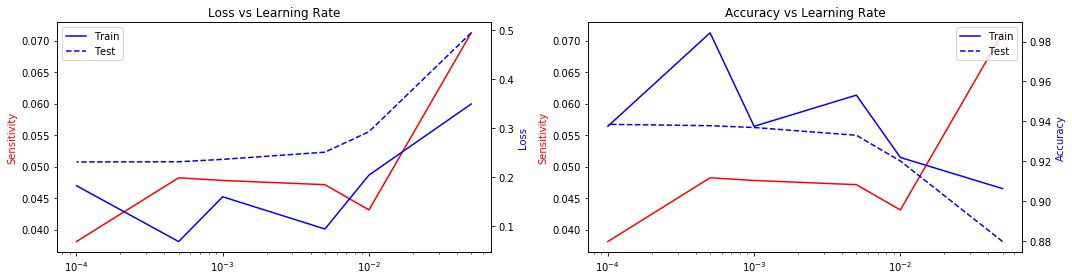

In [68]:
fig,axs=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_tight_layout('tight')
axs[0].plot(lr_list,sens_list3,'r')
axs[0].set_xscale('log')
axs[0].set_ylabel('Sensitivity')
axs[0].yaxis.label.set_color('red')
axs1 = axs[0].twinx()
axs1.plot(lr_list, train_loss_list3,'b')
axs1.plot(lr_list, test_loss_list3,'b--')
axs1.set_xscale('log')
axs1.set_ylabel('Loss')
axs1.yaxis.label.set_color('blue')
axs1.set_xlabel('Learning Rate(log scale)')
axs1.legend(['Train','Test'])
axs1.set_title('Loss vs Learning Rate')

axs[1].plot(lr_list,sens_list3,'r')
axs[1].set_xscale('log')
axs[1].set_ylabel('Sensitivity')
axs[1].yaxis.label.set_color('red')
axs2 = axs[1].twinx()
axs2.plot(lr_list, train_acc_list3,'b')
axs2.plot(lr_list, test_acc_list3,'b--')
axs2.set_ylabel('Accuracy')
axs2.set_xlabel('Learning Rate(log scale)')
axs2.yaxis.label.set_color('blue')
axs2.legend(['Train','Test'])
axs2.set_title('Accuracy vs Learning Rate')

___
## Model 4 Architecture

In [69]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

flat1 = tf.layers.flatten(inputs=input_x)
h1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
h2 = tf.layers.dense(inputs=h1,units=256,activation=tf.nn.relu);
h3 = tf.layers.dense(inputs=h1,units=128,activation=tf.nn.relu);
h4 = tf.layers.dense(inputs=h1,units=64,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=h4,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);
sens_op = tf.norm(tf.gradients(loss,input_x))

In [70]:
train_loss_list4 = []
train_acc_list4 = []
test_loss_list4 = []
test_acc_list4 = []
sens_list4 = []
session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = [4,16,64,256,512,1024,2048,4096]
for i in range(len(BATCH_SIZE)):
    for j in range(int(data.train.num_examples/BATCH_SIZE[i])):
        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE[i])
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list4.append(train_loss)
    train_acc_list4.append(train_acc)
    test_loss, test_acc, sens = session.run([loss,acc_op,sens_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list4.append(test_loss)
    test_acc_list4.append(test_acc)
    sens_list4.append(sens)
    msg = "Batch Size: {0:>4}, Training Loss: {1:>1.4}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.4}, Test Accuracy: {4:>6.1%}, Sensitivity: {5:>1.4}"
    print(msg.format(BATCH_SIZE[i], train_loss, train_acc, test_loss, test_acc, sens))

Batch Size:    4, Training Loss: 0.0006213, Training Accuracy: 100.0%, Test Loss: 0.3026, Test Accuracy:  92.9%, Sensitivity: 0.04019
Batch Size:   16, Training Loss: 0.1591, Training Accuracy:  93.8%, Test Loss: 0.1578, Test Accuracy:  96.0%, Sensitivity: 0.03133
Batch Size:   64, Training Loss: 0.04539, Training Accuracy:  98.4%, Test Loss: 0.1122, Test Accuracy:  97.0%, Sensitivity: 0.02793
Batch Size:  256, Training Loss: 0.03697, Training Accuracy:  99.2%, Test Loss: 0.1043, Test Accuracy:  97.2%, Sensitivity: 0.02862
Batch Size:  512, Training Loss: 0.06769, Training Accuracy:  97.9%, Test Loss: 0.1051, Test Accuracy:  97.2%, Sensitivity: 0.02977
Batch Size: 1024, Training Loss: 0.04545, Training Accuracy:  98.3%, Test Loss: 0.1049, Test Accuracy:  97.1%, Sensitivity: 0.02986
Batch Size: 2048, Training Loss: 0.04086, Training Accuracy:  98.7%, Test Loss: 0.106, Test Accuracy:  97.1%, Sensitivity: 0.03045
Batch Size: 4096, Training Loss: 0.03973, Training Accuracy:  98.8%, Test Lo

Text(0.5, 1.0, 'Accuracy vs Batch Size')

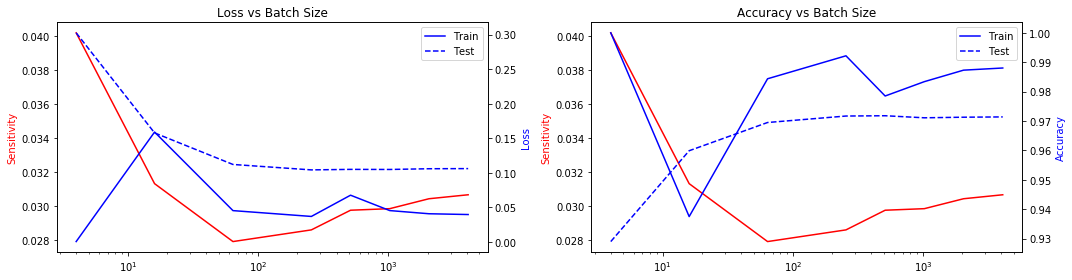

In [71]:
fig,axs=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_tight_layout('tight')
axs[0].plot(BATCH_SIZE,sens_list4,'r')
axs[0].set_xscale('log')
axs[0].set_ylabel('Sensitivity')
axs[0].yaxis.label.set_color('red')
axs1 = axs[0].twinx()
axs1.plot(BATCH_SIZE, train_loss_list4,'b')
axs1.plot(BATCH_SIZE, test_loss_list4,'b--')
axs1.set_xscale('log')
axs1.set_ylabel('Loss')
axs1.yaxis.label.set_color('blue')
axs1.set_xlabel('Batch Size(log scale)')
axs1.legend(['Train','Test'])
axs1.set_title('Loss vs Batch Size')

axs[1].plot(BATCH_SIZE,sens_list4,'r')
axs[1].set_xscale('log')
axs[1].set_ylabel('Sensitivity')
axs[1].yaxis.label.set_color('red')
axs2 = axs[1].twinx()
axs2.plot(BATCH_SIZE, train_acc_list4,'b')
axs2.plot(BATCH_SIZE, test_acc_list4,'b--')
axs2.set_ylabel('Accuracy')
axs2.yaxis.label.set_color('blue')
axs2.set_xlabel('Batch Size(log scale)')
axs2.legend(['Train','Test'])
axs2.set_title('Accuracy vs Batch Size')

## Model 5 Architecture

In [72]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

flat1 = tf.layers.flatten(inputs=input_x)
h1 = tf.layers.dense(inputs=flat1,units=128,activation=tf.nn.relu);
h2 = tf.layers.dense(inputs=h1,units=256,activation=tf.nn.relu);
h3 = tf.layers.dense(inputs=h1,units=64,activation=tf.nn.relu);
logits = tf.layers.dense(inputs=h3,units=num_classes,activation=None);
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits);
loss = tf.reduce_mean(cross_entropy);

# Accuracy
softmax = tf.nn.softmax(logits=logits);
pred_op = tf.argmax(softmax,dimension=1);
acc_op = tf.reduce_mean(tf.cast(tf.equal(pred_op, y_cls), tf.float32));
optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
train_op = optimizer.minimize(loss);
sens_op = tf.norm(tf.gradients(loss,input_x))

### Model 5 Training

In [75]:
train_loss_list5 = []
train_acc_list5 = []
test_loss_list5 = []
test_acc_list5 = []
sens_list5 = []
session = tf.Session()
session.run(tf.global_variables_initializer())

BATCH_SIZE = [4,16,64,256,512,1024,2048,4096]
for i in range(len(BATCH_SIZE)):
    for j in range(int(data.train.num_examples/BATCH_SIZE[i])):
        x_batch, y_true_batch = data.train.next_batch(BATCH_SIZE[i])
        session.run(train_op, feed_dict={x: x_batch,y: y_true_batch})
    train_loss, train_acc = session.run([loss,acc_op],feed_dict={x:x_batch,y:y_true_batch})
    train_loss_list5.append(train_loss)
    train_acc_list5.append(train_acc)
    test_loss, test_acc, sens = session.run([loss,acc_op,sens_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list5.append(test_loss)
    test_acc_list5.append(test_acc)
    sens_list5.append(sens)
    msg = "Batch Size: {0:>4}, Training Loss: {1:>1.4}, Training Accuracy: {2:>6.1%}, Test Loss: {3:>1.4}, Test Accuracy: {4:>6.1%}, Sensitivity: {5:>1.4}"
    print(msg.format(BATCH_SIZE[i], train_loss, train_acc, test_loss, test_acc, sens))

Batch Size:    4, Training Loss: 0.04552, Training Accuracy: 100.0%, Test Loss: 0.2068, Test Accuracy:  94.2%, Sensitivity: 0.02965
Batch Size:   16, Training Loss: 0.01287, Training Accuracy: 100.0%, Test Loss: 0.1561, Test Accuracy:  95.6%, Sensitivity: 0.02987
Batch Size:   64, Training Loss: 0.04009, Training Accuracy:  98.4%, Test Loss: 0.1147, Test Accuracy:  96.9%, Sensitivity: 0.02752
Batch Size:  256, Training Loss: 0.09768, Training Accuracy:  97.7%, Test Loss: 0.1061, Test Accuracy:  97.3%, Sensitivity: 0.02669
Batch Size:  512, Training Loss: 0.04553, Training Accuracy:  98.6%, Test Loss: 0.1067, Test Accuracy:  97.3%, Sensitivity: 0.02767
Batch Size: 1024, Training Loss: 0.04531, Training Accuracy:  98.8%, Test Loss: 0.1064, Test Accuracy:  97.3%, Sensitivity: 0.02793
Batch Size: 2048, Training Loss: 0.05392, Training Accuracy:  98.2%, Test Loss: 0.1063, Test Accuracy:  97.4%, Sensitivity: 0.02809
Batch Size: 4096, Training Loss: 0.04297, Training Accuracy:  98.8%, Test Lo

Text(0.5, 1.0, 'Accuracy vs Batch Size')

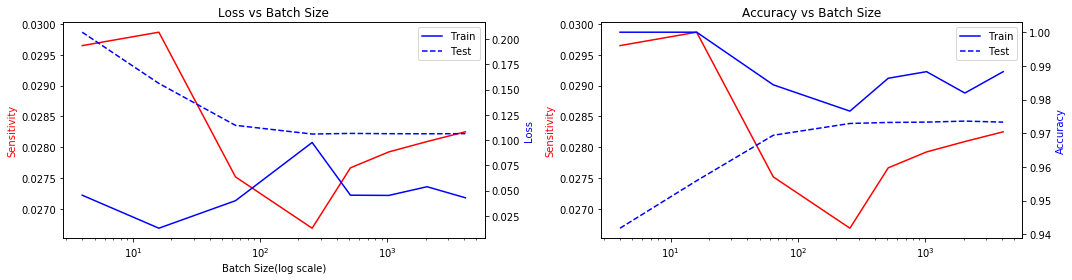

In [76]:
fig,axs=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_tight_layout('tight')
axs[0].plot(BATCH_SIZE,sens_list5,'r')
axs[0].set_xscale('log')
axs[0].set_ylabel('Sensitivity')
axs[0].yaxis.label.set_color('red')
axs[0].set_xlabel('Batch Size(log scale)')
axs1 = axs[0].twinx()
axs1.plot(BATCH_SIZE, train_loss_list5,'b')
axs1.plot(BATCH_SIZE, test_loss_list5,'b--')
axs1.set_xscale('log')
axs1.set_ylabel('Loss')
axs1.yaxis.label.set_color('blue')
axs1.legend(['Train','Test'])
axs1.set_title('Loss vs Batch Size')

axs[1].plot(BATCH_SIZE,sens_list5,'r')
axs[1].set_xscale('log')
axs[1].set_ylabel('Sensitivity')
axs[1].yaxis.label.set_color('red')
axs2 = axs[1].twinx()
axs2.plot(BATCH_SIZE, train_acc_list5,'b')
axs2.plot(BATCH_SIZE, test_acc_list5,'b--')
axs2.set_ylabel('Accuracy')
axs2.yaxis.label.set_color('blue')
axs2.set_xlabel('Batch Size(log scale)')
axs2.legend(['Train','Test'])
axs2.set_title('Accuracy vs Batch Size')